In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


Ensemble related sources:<br>
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/ <br>
https://www.kaggle.com/kokitanisaka/moa-ensemble<br>
<br>
Notebooks used for individual models:<br>
<br>
Logistic Regression:<br>
https://www.kaggle.com/sg1993/logistic-regression-model/notebook<br>
https://www.kaggle.com/barteksadlej123/basic-logistic-regression<br>
<br>
LightGBM:<br>
https://www.kaggle.com/nroman/moa-lightgbm-206-models<br>
https://www.kaggle.com/pavelvpster/moa-lgb-optuna<br>
<br>
FNN:<br>
https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2/notebook<br>
https://www.kaggle.com/elcaiseri/moa-keras-multilabel-classifier-nn-starter/notebook<br>
https://www.kaggle.com/gogo827jz/moa-lstm-pure-transformer-fast-and-not-bad/notebook?scriptVersionId=42679125<br>

## Reading data

In [2]:
path = "/kaggle/input/lish-moa/"
train_features = pd.read_csv(path+"train_features.csv")
test_features = pd.read_csv(path+"test_features.csv")
train_targets_scored = pd.read_csv(path+"train_targets_scored.csv")
sub = pd.read_csv(path+"sample_submission.csv")

# From https://www.kaggle.com/carlmcbrideellis/moa-setting-ctl-vehicle-0-improves-score
train_features.at[train_features['cp_type'].str.contains('ctl_vehicle'),train_features.filter(regex='-.*').columns] = 0.0
test_features.at[test_features['cp_type'].str.contains('ctl_vehicle'),test_features.filter(regex='-.*').columns] = 0.0

## General data processing

In [3]:
def onehotencode(data):
    data = pd.get_dummies(data)
    return data

In [4]:
# Dropping sig_id columns and onehot encoding

X_test = test_features.copy()
X_train = train_features.copy()
y_train = train_targets_scored.copy()
X_train = X_train.drop("sig_id", axis=1)
y_train = y_train.drop("sig_id", axis=1)

# changing cp_time to categorical before onehotencoding
X_test = test_features.copy()
X_train['cp_time'] = X_train['cp_time'].apply(lambda x:str(x))
X_test['cp_time'] = X_test['cp_time'].apply(lambda x:str(x))

X_train = onehotencode(X_train)

sig_id = X_test["sig_id"]  # getting the ids
X_test = X_test.drop("sig_id", axis=1)
X_test = onehotencode(X_test)

columns = X_test.columns  # getting the feature columns
sub = pd.read_csv(path+"sample_submission.csv")

## Stacking

In [5]:
def stacking_gbm(train,y,test,n_fold,params):
    folds=KFold(n_splits=n_fold)
    test_pred = pd.DataFrame(columns=y.columns)
    train_pred = pd.DataFrame(columns=y.columns)
    # 206 different models. One for each label
    for model, target in enumerate(y_train, 1):
        y_col = y_train[target]
        preds_train = np.zeros(train.shape[0])
        preds_test = np.zeros(test.shape[0])
        for trn_idx,test_idx in folds.split(train):
            trn_data = lgb.Dataset(train.iloc[trn_idx], label=y_col.iloc[trn_idx])
            val_data = lgb.Dataset(train.iloc[test_idx], label=y_col.iloc[test_idx])

            clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds=20)
            preds_train[test_idx] = clf.predict(train.iloc[test_idx])
            preds_test += clf.predict(test) / folds.n_splits
        train_pred[target] = preds_train
        test_pred[target] = preds_test

    return test_pred,train_pred

def stacking_nn(model, train, y, test, n_fold):
    folds=KFold(n_splits=n_fold)
    test_pred = pd.DataFrame(columns=y.columns)
    train_pred = pd.DataFrame(columns=y.columns)
    for train_indices,val_indices in folds.split(train):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

        model.fit(x_train, y_train, batch_size=32, validation_split=0.2, verbose=0, epochs=100)
        train_preds = pd.DataFrame(model.predict_proba(x_val), columns=y.columns)
        train_pred = train_pred.append(train_preds, ignore_index=True)
    model.fit(train, y, batch_size=32, validation_split=0.2, verbose=0, epochs=100)
    test_preds = pd.DataFrame(model.predict_proba(test), columns=y.columns)
    test_pred = test_pred.append(test_preds, ignore_index=True)
    return test_pred,train_pred

def stacking_logreg(model, train, y, test, n_fold):
    folds=KFold(n_splits=n_fold)
    test_pred = pd.DataFrame(columns=y.columns)
    train_pred = pd.DataFrame(columns=y.columns)
    for train_indices,val_indices in folds.split(train):
        x_trn,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_trn,y_val=y.iloc[train_indices],y.iloc[val_indices]
        
        for col in y_train.columns:  # for when a split has only 0s as targets in a column
            y_trn = y_trn.copy()
            if (y_trn[col] == 0).all():
                y_trn[col].iloc[0] = 1  # change first element to 1
                
        model.fit(x_trn, y_trn)
        train_preds = model.predict_proba(x_val)
        train_preds = np.array(train_preds)[:,:,1]
        train_preds = pd.DataFrame(train_preds.T, columns=y.columns)
        train_pred = train_pred.append(train_preds, ignore_index=True)
    model.fit(train, y)
    test_preds = model.predict_proba(test)
    test_preds = np.array(test_preds)[:,:,1]
    test_preds = pd.DataFrame(test_preds.T, columns=y.columns)
    test_pred = test_pred.append(test_preds, ignore_index=True)
    return test_pred,train_pred

## Base Models

### Logistic Regression

In [6]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,c-97,c-98,c-99,cp_type_ctl_vehicle,cp_type_trt_cp,cp_time_24,cp_time_48,cp_time_72,cp_dose_D1,cp_dose_D2
0,0.587495,0.819669,-0.404962,-0.758524,-0.277536,-0.774113,-1.235604,0.142506,0.448638,-0.177931,...,0.358523,0.479884,0.533100,-0.29158,0.29158,1.436689,-0.728059,-0.697375,0.980043,-0.980043
1,-0.132368,0.626207,0.144569,-0.015806,0.957312,0.574388,0.266602,0.480924,-0.106182,0.713380,...,0.305291,0.605019,0.763341,-0.29158,0.29158,-0.696045,-0.728059,1.433950,0.980043,-0.980043
2,0.271184,0.850831,1.405277,-0.164960,-0.112571,1.206363,0.191737,0.369552,0.131590,1.071966,...,0.102085,-0.503215,0.731634,-0.29158,0.29158,-0.696045,1.373516,-0.697375,0.980043,-0.980043
3,-0.560991,-0.227885,-0.422744,0.494894,4.054101,-0.595949,-2.356190,0.336332,0.051446,-1.092973,...,-0.288974,0.057802,-0.355437,-0.29158,0.29158,-0.696045,1.373516,-0.697375,0.980043,-0.980043
4,-0.423680,-0.424983,0.818574,0.672723,1.363365,-0.609059,-0.348225,0.035252,-0.380383,0.725009,...,0.402744,0.062750,0.745614,-0.29158,0.29158,-0.696045,-0.728059,1.433950,-1.020364,1.020364


In [7]:
model0 = MultiOutputClassifier(LogisticRegression(C=0.01, solver="sag", max_iter=200, random_state=0), n_jobs=-1)

In [8]:
test_pred0, train_pred0 = stacking_logreg(model=model0, n_fold=3, train=X_train_scaled, test=X_test_scaled, y=y_train.copy())

In [9]:
print(train_pred0.shape)
print(test_pred0.shape)
print(train_pred0.head())
print(test_pred0.head())

(23814, 206)
(3982, 206)
   5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                     0.004778                0.006790        0.002768   
1                     0.003462                0.003832        0.004392   
2                     0.003563                0.003301        0.005360   
3                     0.003942                0.005014        0.003191   
4                     0.002293                0.004487        0.008529   

   acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                        0.012949                           0.124682   
1                        0.009566                           0.019255   
2                        0.001522                           0.023335   
3                        0.001999                           0.003640   
4                        0.016428                           0.003998   

   acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                        0.00853

### Feed Forward Neural Network

In [10]:
def create_model(n_input):
    model = Sequential()
    model.add(Input(n_input))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(300, kernel_initializer='he_uniform', activation='sigmoid'))
    model.add(Dropout(0.6)) 
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dropout(0.6))
    model.add(Dense(700, activation='sigmoid'))
    model.add(Dropout(0.6))
    model.add(Dense(206, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    return model

In [11]:
model1 = create_model(len(columns))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 879)               3516      
_________________________________________________________________
dropout (Dropout)            (None, 879)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               264000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 700)               2

In [12]:
test_pred1, train_pred1 = stacking_nn(model=model1, n_fold=5, train=X_train, test=X_test, y=y_train)

In [13]:
print(train_pred1.shape)
print(test_pred1.shape)
print(train_pred1.head())
print(test_pred1.head())

(23814, 206)
(3982, 206)
   5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                 1.416117e-03                0.000848        0.001309   
1                 8.681118e-04                0.001084        0.001770   
2                 1.368046e-03                0.001447        0.001284   
3                 4.037938e-07                0.000021        0.001383   
4                 6.737411e-04                0.001244        0.001796   

   acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                        0.012809                           0.024730   
1                        0.013225                           0.019984   
2                        0.005881                           0.015284   
3                        0.001813                           0.000188   
4                        0.013523                           0.019065   

   acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                        0.00395

### LightGBM

In [14]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': "gbdt",
    'num_leaves': 500,
    'min_child_weight': 0.01,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'min_data_in_leaf': 100,
    'max_depth': -1,
    'learning_rate': 0.01,
    'bagging_seed': 11,
    'verbosity': 0,
    'reg_alpha': 0.4,
    'reg_lambda': 0.6,
    'random_state': 0
         }

test_pred2, train_pred2 = stacking_gbm(n_fold=3, train=X_train, test=X_test, y=y_train, params=params)

In [15]:
print(train_pred2.shape)
print(test_pred2.shape)
print(train_pred2.head())
print(test_pred2.head())

(23814, 206)
(3982, 206)
   5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                     0.000690                0.000178        0.001004   
1                     0.000687                0.000264        0.001011   
2                     0.000690                0.000713        0.001004   
3                     0.000687                0.000439        0.001045   
4                     0.000690                0.000153        0.001109   

   acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                        0.005602                           0.012616   
1                        0.007729                           0.007978   
2                        0.006266                           0.009222   
3                        0.005178                           0.004784   
4                        0.007295                           0.011268   

   acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                        0.00152

### Meta learning NN

In [16]:
df_train = pd.concat([train_pred0, train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred0, test_pred1, test_pred2], axis=1)
print(df_train.shape)
print(y_train.shape)
print(df_test.shape)
print(df_train.head())
print(df_test.head())

(23814, 618)
(23814, 206)
(3982, 618)
   5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                     0.004778                0.006790        0.002768   
1                     0.003462                0.003832        0.004392   
2                     0.003563                0.003301        0.005360   
3                     0.003942                0.005014        0.003191   
4                     0.002293                0.004487        0.008529   

   acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                        0.012949                           0.124682   
1                        0.009566                           0.019255   
2                        0.001522                           0.023335   
3                        0.001999                           0.003640   
4                        0.016428                           0.003998   

   acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                  

In [17]:
def create_meta_model(n_input):
    model = Sequential()
    model.add(Input(n_input))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation="sigmoid"))
    model.add(Dropout(0.6))
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dropout(0.6))
    model.add(Dense(206, activation="sigmoid"))
    model.compile(optimizer="adamax", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
meta_model = create_meta_model(df_train.shape[1])
meta_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 618)               2472      
_________________________________________________________________
dropout_4 (Dropout)          (None, 618)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              633856    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 206)              

In [19]:
hist = meta_model.fit(df_train, y_train, batch_size=32, validation_split=0.2, verbose=1, epochs=20)

Epoch 1/20
596/596 [==============================] - 7s 12ms/step - loss: 0.0322 - accuracy: 0.0130 - val_loss: 0.0210 - val_accuracy: 0.0334
Epoch 2/20
596/596 [==============================] - 7s 12ms/step - loss: 0.0221 - accuracy: 0.0259 - val_loss: 0.0195 - val_accuracy: 0.0617
Epoch 3/20
596/596 [==============================] - 7s 12ms/step - loss: 0.0207 - accuracy: 0.0392 - val_loss: 0.0184 - val_accuracy: 0.0798
Epoch 4/20
596/596 [==============================] - 7s 12ms/step - loss: 0.0193 - accuracy: 0.0701 - val_loss: 0.0175 - val_accuracy: 0.0794
Epoch 5/20
596/596 [==============================] - 7s 12ms/step - loss: 0.0184 - accuracy: 0.0873 - val_loss: 0.0170 - val_accuracy: 0.0928
Epoch 6/20
596/596 [==============================] - 7s 11ms/step - loss: 0.0179 - accuracy: 0.0960 - val_loss: 0.0166 - val_accuracy: 0.1037
Epoch 7/20
596/596 [==============================] - 7s 12ms/step - loss: 0.0174 - accuracy: 0.0997 - val_loss: 0.0163 - val_accuracy: 0.1033

Text(0.5, 1.0, 'Accuracy')

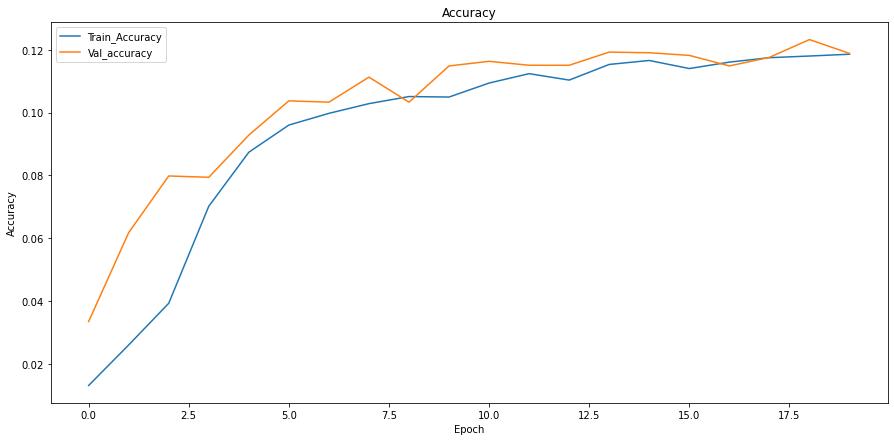

In [20]:
# Draw fitting info
plt.figure(figsize=(15, 7))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train_Accuracy', 'Val_accuracy'])
plt.title('Accuracy')


In [21]:
preds = meta_model.predict(df_test)
submission = pd.DataFrame.from_records(preds)
submission.insert(0, "sig_id", sig_id)
submission.columns = sub.columns
submission.to_csv('submission.csv', index=False)